In [1]:
import torch 
import logging
import random 
from mlca_for_elec.networks.main import eval_config
import os
import matplotlib.pyplot as plt
from mlca_for_elec.env.env import Microgrid, HouseHold
from mlca_for_elec.mlca_elec.mlca import *
import json
import numpy as np
from collections import defaultdict
import pandas as pd

Class NN_MIP_TORCH imported
Class MLCA_WDP imported
Class MLCA_Economies imported
FUNCTION MLCA imported


In [2]:
os.getcwd()
os.chdir("c:\\Users\\pieples\\Documents\\MLICA-for-elec\\")

In [3]:
exp_number = 1

In [4]:
household_path = f"config\experiment{exp_number}\households"
microgrid_path = f"config\experiment{exp_number}\microgrid\exp{exp_number}_microgrid.json"
dataset_path = f"config\experiment{exp_number}\dataset"

In [56]:
%matplotlib inline
print("Start loading household profiles")
folder_path = household_path
houses = []
for file in os.listdir(folder_path)[:3]:
    if file.endswith(".json"):
        household = json.load(open(folder_path+"/"+ file))
    house = HouseHold(household, horizon =1)

    generation_path = "data\solar_prod\Timeseries_55.672_12.592_SA2_1kWp_CdTe_14_44deg_-7deg_2020_2020.csv"
    consumption_path = f"data/consumption/Reference-{house.param['consumption']['type']}.csv"
    spot_price_path = "data/spot_price/2020.csv"
    fcr_price_path = "data/fcr_price/random_fcr.csv"
    profile_path_train = dataset_path + f"/dataset_{house.ID}.csv"
    profile_path_valtest = dataset_path + f"/test_dataset_{house.ID}.csv"
    house.load_data(generation_path,consumption_path, spot_price_path,fcr_price_path, profile_path_train, profile_path_valtest,type = float)
    for i in range(0):
        house.next_data()
    houses.append(house)
print(f"Loaded {len(houses)} households")
print("Start compute social welfare")
print(list(houses[0].data['consumption'].to_numpy()))
microgrid_1 =json.load(open( microgrid_path))
MG = Microgrid(houses, microgrid_1)
optimal_allocation = {}
for house in MG.households:
    print(house.data['consumption'].sum())
    optimal_allocation_tuple = MG.get_efficient_allocation()
    optimal_allocation[house.ID] = (optimal_allocation_tuple[0][house.ID] , MG.calculate_value(house.ID, optimal_allocation_tuple[0][house.ID]))
MG.generate_dataset(0,dataset_path,1000)
MG.generate_test_dataset(0,dataset_path,1000)

Start loading household profiles
0
1
2
Loaded 3 households
Start compute social welfare
[1.3486959329357744]
1.3486959329357744
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.47009925686207
  Upper bound: 0.47009925686207
  Number of objectives: 1
  Number of constraints: 36
  Number of variables: 32
  Number of nonzeros: 75
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0


100%|██████████| 1000/1000 [00:00<00:00, 8481.93it/s]


In [38]:
df = pd.read_csv("config\experiment1\dataset\dataset_1.csv")
df

,Unnamed: 0,0,1,2,3,4,5,value
0,0,3.937449,3.727817,2.516272,2.603639,2.774067,0.370565,1.289214
1,1,3.161363,2.063279,1.870117,1.954225,3.523567,3.149503,1.745692
2,2,0.501057,3.220460,0.857788,3.479591,2.592845,3.878073,1.538101
3,3,1.992918,2.456589,2.974973,1.194818,1.803119,3.942399,1.745692
4,4,1.593899,0.824048,3.484309,1.818884,1.190061,0.434043,1.175536
...,...,...,...,...,...,...,...,...
995,995,2.052129,2.869933,1.746436,0.564885,1.369617,1.622482,1.410668
996,996,1.388131,2.755270,0.873783,2.677838,2.783378,3.554798,1.711167
997,997,3.568907,1.193323,1.470002,2.680135,3.735022,0.812311,1.377737
998,998,2.003616,0.627322,2.235652,1.542521,0.188148,3.239647,1.379094


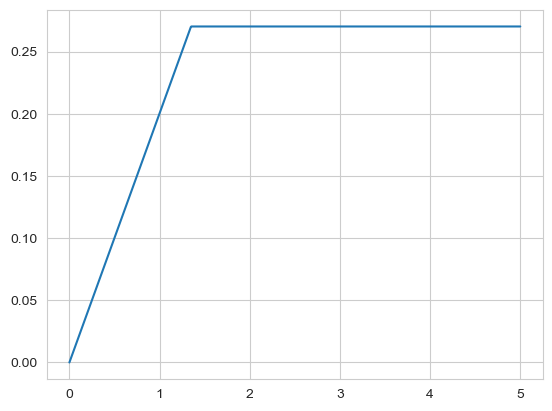

In [47]:
x = np.linspace(0, 5, 1000)
y = [MG.calculate_value(1, i) for i in x]



In [57]:
def evaluate_network(cfg: dict, seed: int, MicroGrid_instance: str, bidder_id: str, num_train_data: int, layer_type: str,
                     normalize: bool, normalize_factor: float, eval_test=False, save_datasets=False):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return eval_config(
        seed=seed, SAT_instance=MicroGrid_instance, bidder_id=bidder_id,
        layer_type=layer_type, batch_size=cfg['batch_size'], num_hidden_layers=cfg['num_hidden_layers'],
        num_hidden_units=int(max(1, np.round(cfg['num_neurons'] / cfg['num_hidden_layers']))), l2=cfg['l2'], l1 = 0,
        lr=cfg['lr'], normalize_factor=normalize_factor, optimizer=cfg['optimizer'], num_train_data=num_train_data,
        eval_test=True, epochs=cfg['epochs'], loss_func=cfg['loss_func'], normalize=normalize, save_datasets=False, log_path="logs")

In [59]:
config_dict = {"batch_size": 1,
        "epochs":300,
        "l2": 1e-5,
        "loss_func": "F.l1_loss",
        "lr": 0.0001,
        "num_hidden_layers":3,
        "num_neurons": 50,
        "optimizer": "Adam"
    }

print('Selected hyperparameters', config_dict)
model, logs = evaluate_network(
    config_dict, seed=0, MicroGrid_instance=MG, bidder_id=0,
    num_train_data=100, layer_type="PlainNN",
    normalize=True,
    normalize_factor=1)
train_logs = logs['metrics']['train'][config_dict['epochs']]
val_logs = logs['metrics']['val'][config_dict['epochs']]
test_logs = logs['metrics']['test'][config_dict['epochs']]

print('Train metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(train_logs['r'], train_logs['kendall_tau']))
print('Valid metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(val_logs['r'], val_logs['kendall_tau']))
print('Test metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(test_logs['r'], test_logs['kendall_tau']))

Selected hyperparameters {'batch_size': 1, 'epochs': 300, 'l2': 1e-05, 'loss_func': 'F.l1_loss', 'lr': 0.0001, 'num_hidden_layers': 3, 'num_neurons': 50, 'optimizer': 'Adam'}
Dataset size : Train (100, 1), Val (400000, 24), Test (1600000, 24)
(100, 1) (100,) (400000, 24) (400000,) (1600000, 24) (1600000,)


 32%|███▏      | 96/300 [00:14<00:30,  6.76it/s]